Lista #3 MCMC
===

Thiago da Mota Souza - thiagosz@cos.ufrj.br

## Imports

In [1]:
import math
import numpy as np
import random
import time
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import requests
import scipy.special
from multiprocessing import Pool
from tqdm import tqdm
from decimal import Decimal

## Questão 1

Usando a mesma ideia da utilizada em sala de aula, podemos considerar o sorteio de pontos dentro de um quadrado de lado unitário que estão contidos em um triângulo $ABC$ de lados $\overline{AB}=1$, $\overline{AC}=1$ e $\angle{BAC} = \alpha = \pi/4$. A área desse triângulo é:

$$
\begin{equation}
Area(ABC) = \frac{\sin{(\alpha)}x1x1}{2} = \frac{\sqrt{2}}{4}
\end{equation}
$$

### Questão 1.1

Estabelecendo o vértice A como a origem do sistema de coordenadas, o eixo $x$ congruente ao lado $AC$ e o eixo $y$ perpendicular ao eixo $x$ como o de costume. Assim temos: $A = (0,0)$, $B=\sqrt{2}/2(1,1)$ e $C=(1,0)$

Podemos definir as funções determinísticas, $f_{AB}$ e $f_{BC}$, que descrevem os lados $AB$ e $BC$ respectivamente nos nos intervalos $x \in [0,1/2]$ e $x \in [1/2,1]$

$$
\begin{equation}
f_{AB} = \sqrt{2}x
\end{equation}
$$

$$
\begin{equation}
f_{BC} = -\sqrt{2}x + \sqrt{2}
\end{equation}
$$

E portanto vamos definir a função $g$ que descreve da sequinte forma

$$
g(x) = 
     \begin{cases}
       \sqrt{2}x & 0 \geq x < 1/2 \\
       -\sqrt{2}x + \sqrt{2}, & 1/2 < x \leq 1 \\
     \end{cases}
$$

> OBS: eu entendo que devido as constantes da função g, o que segue tem uma falha que é eu ter que usar o valor de $\sqrt{2}$ no computo de g. Não tenho tempo para bolar uma outra forma geométrica que escape à isso e vou seguir a questão ignorando esse fato que não altera o uso de Monte Carlo em si.

Utilizando a mesma ideia da usada para achar $\pi$ em sala de aula, podemos estimar a área em baixo dda função $g$ no intervalo $[0,1]$ Para isso devemos definir: $X,Y \sim Uniforme(0,1)$. Por tanto:

$$
\begin{equation}
\label{eq:Q-1-area-int}
Area(ABC) = \int_{x=0}^{1}g(x)dx = E[g(X)] = \frac{\sqrt(2)}{4}
\end{equation}
$$


### Questão 1.2

da questão anterior, temos que:

$$
\begin{equation}
\sigma_{g(X)}^2 = E[(g(X)- \mu_{g(x)})^2] = E[g(X)^2] - \mu_{g(X)}^2
\end{equation}
$$

A média, $\mu_{g(X)}$ foi construida a partir da área do triângulo e portanto já sabemos que seu valor é $\sqrt{2}{4}$, mas isso pode ser verificado por:

$$
\begin{multline}
\mu_{g(X)} = E[g(X)] = \int_{0}^{1/2}\sqrt{2}xdx + \int_{1/2}^{1}(-\sqrt{2}x + \sqrt{2})dx = \\
\frac{\sqrt{2}}{2}x^2\bigg\rvert_{0}^{1/2} + \sqrt(2)\left(-1/2x^2 + x\right)\bigg\rvert_{1/2}^{1} = \frac{\sqrt{2}}{8} \frac{\sqrt{2}}{8} = \frac{\sqrt{2}}{4}
\end{multline}
$$

Para o cálculo de $\sigma_{g(X)}^2$, temos:

$$
\begin{multline}
E[g(X)^2] = \int_{0}^{1/2}2x^2dx + \int_{1/2}^{1}(x^2 -4x + 2)dx = \\
\frac{2}{3}x^3\bigg\rvert_{0}^{1/2} + (1/3x^3 -2x^2 + 2x)\bigg\rvert_{1/2}^{1} = \frac{2}{24} + \frac{19}{24} = \frac{7}{8}
\end{multline}
$$

logo:
$$
\begin{equation}
\sigma_{g(X)}^2 = E[(g(X)- \mu_{g(x)})^2] = E[g(X)^2] - \mu_{g(X)}^2 = \frac{7}{8} - \frac{1}{8} = \frac{3}{4}
\end{equation}
$$


### Questão 1.3

da documentação da biblioteca [numpy](https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html) do python, temos que a função ```numpy.random.MT19937``` usa o algoritmo de Mersenne Twister.

In [2]:
def generate_sample(g_fun, sample_sz, a=0,b=1):
    """Gerador genérico de amostras da função g aplicada sobre uma distribuição uniforme X no intervalo [a,b]"""
    vectorized_g_fun = np.vectorize(g_fun)
    
    x_list = np.random.uniform(a,b,sample_sz)
    
    return vectorized_g_fun(x_list), x_list

In [3]:
def g_fun(x):
    if x < 0.5:
        return math.sqrt(2)*x
    return math.sqrt(2)*(-x+1)

### Questão 1.4

fazendo a correção para a definção de erro do meu estimador, uma vez que a V.A. que eu estou gerando não tem expectativa $\sqrt(2)$, mas sim $\sqrt(2)/4$ 

$$
\begin{equation}
\hat{e}_{n} = \frac{|M_n - \sqrt{2}/4|}{\sqrt{2}/4}
\end{equation}
$$

Essa é a função de erro MAE (Mean absolute error)

> Como sabemos que a média amostral tem uma variância, vou utilizar K-folds para visualizar a variância do estimador

In [4]:
def mae(y_true, y_pred):
    return abs(y_true - y_pred)/y_true
mae = np.vectorize(mae)

In [5]:
def sanple_mean_estimator(values):
    return np.mean(values)

In [6]:
def run_mc_estimator(sample_gen, sample_size, mae, estimator, true_val, num_folds=5):
    
    sample_sz_compansate_folds = math.ceil((num_folds+1)*sample_size/num_folds)
    samples,_ = sample_gen(sample_sz_compansate_folds)
    
    num_folds = min(sample_sz_compansate_folds, num_folds)
    
    kf = KFold(n_splits=num_folds, shuffle=False)
    estimate_sample = []
    error_sample = []
    for fold,_ in kf.split(samples):
        data = samples[fold]
        estimate = estimator(data)
        estimate_sample.append(estimate)
        if true_val:
            error = mae(true_val, estimate)
            error_sample.append(error)
        
    return estimate_sample, error_sample

In [7]:
def g_sample_generator(sample_sz):
    global g_fun
    return generate_sample(g_fun, sample_sz, 0,1)

def run_experiments(min_sample_sz, max_sample_sz):
    global g_sample_generator, run_mc_estimator, mae, sanple_mean_estimator
    
    true_val = math.sqrt(2)/4
    range_len = max_sample_sz - min_sample_sz + 1
    estimates = np.zeros([5, range_len])
    errors = np.zeros([5, range_len])
    
    for i,sample_sz in enumerate(tqdm(range(min_sample_sz, max_sample_sz + 1))):
        estimates_for_n, error_samples_for_n = run_mc_estimator(g_sample_generator, sample_sz, mae, sanple_mean_estimator, true_val)
        estimates[:,i] = estimates_for_n
        errors[:,i] = error_samples_for_n
    return estimates, errors

In [8]:
%%time
max_sample_size = int(1e4)
estimates, errors = run_experiments(5,max_sample_size)

100%|██████████| 9996/9996 [00:18<00:00, 546.47it/s] 

CPU times: user 18.3 s, sys: 52.5 ms, total: 18.3 s
Wall time: 18.3 s


In [26]:
def plot_experiment1(estimates, error, true_val):
    
    fig = plt.figure(figsize=(10, 8))
    plt.title('estimativa usando MC')
    plt.subplot(2,1,1)
    plt.plot(estimates.T, 'x', color='blue');
    plt.axhline(y=true_val, color='r', linestyle='-')
    plt.grid(True)
    plt.xlabel('tamanho da amostra')
    plt.ylabel('estimativa')
    
    plt.subplot(2,1,2)
    plt.plot(error.T, 'x', color='blue');
    plt.axhline(y=0, color='r', linestyle='-')
    plt.grid(True)
    plt.xlabel('tamanho da amostra')
    plt.ylabel('mae')
    
    fig.subplots_adjust(top=0.85)
    plt.show()

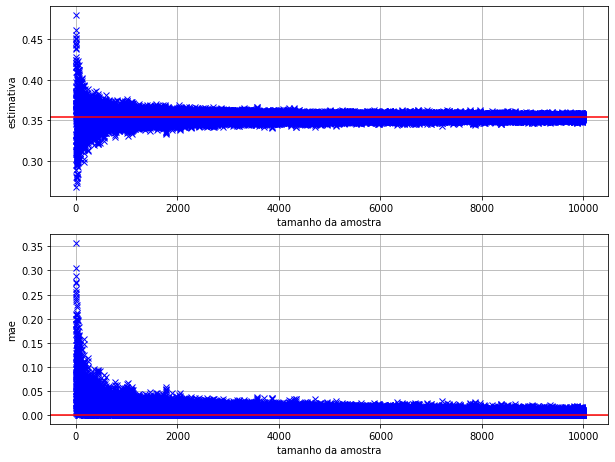

In [10]:
plot_experiment1(estimates, errors, math.sqrt(2)/4)

## Questão 2

### Questão 2.1

$$
\begin{equation}
f_X(x) = \lambda e^{-\lambda x} \implies F_X(x) = -e^{-\lambda x}
\end{equation}
$$

Logo

$$
\begin{equation}
F_X^{-}1(x) = \frac{1}{-\lambda}ln(x)
\end{equation}
$$

In [35]:
def direct_q2_1(x,lam):
    return lam*math.exp(-lam*x)
def inversa_q2_1(x, lam):
    return -(math.log(x)/lam)

Usando o método da inversa podemos criar o seguinte função geradora de amostrar para a distribuição

In [36]:
def sample_generator_q_21(sample_sz, lam):
        
    def param_inv(x):
        global inversa_q2_1
        return inversa_q2_1(x, lam)
    
    sample, x = generate_sample(param_inv, sample_sz, 0,1)
    return sample, x

In [73]:
len_sample = 1000
par_q21 = 4
sample_q21, x = np.array(sample_generator_q_21(len_sample, par_q21))
ran = np.linspace(np.min(sample_q21),np.max(sample_q21),num=len_sample)
distribution_q21 = [direct_q2_1(a, par_q21) for a in ran]

In [76]:
def plot_hist(sample, expected, ran):
    fig = plt.figure()
    ax = plt.hist(sample,density=True)
    plt.plot(ran, expected, '-r')
    plt.title("histograma da ddistribuição")
    plt.xlabel("X")
    plt.ylabel("freq")
    plt.grid(True)
    plt.show()

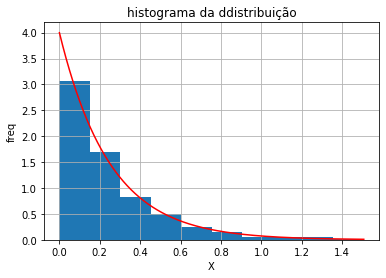

In [77]:
plot_hist(sample_q21,distribution_q21,ran)

### Questão 2.2

$$
\begin{equation}
f_X(x) = \begin{cases}
\frac{\alpha x_0^\alpha}{x^{\alpha+1}} & x > x_0 \\
0 & \text{caso contrário}
\end{cases} 
\implies F_X(x) = \begin{cases}
1 - \left(\frac{x_0^\alpha}{x}\right)^\alpha & x > x_0 \\
0 & \text{caso contrário}
\end{cases}
\end{equation} 
$$

logo

$$
\begin{equation}
F_X^{-1}(x) =
\frac{x_0}{(x-1)^{1/\alpha}}, x \in [0,1]
\end{equation}
$$

No intervalo $[0,x_0)$ a função não é de fato inversível, mas isso não importa uma vez que a distribuição de massa neste invervalo é 0.

In [118]:
def direct_q2_2(x, alpha, x0):
    if x < x0:
        return 0
    return alpha*(x0**alpha)/(x**(alpha+1))
def inversa_q2_2(x, alpha, x0):
    return x0/((1-x)**(1/alpha))

In [129]:
def sample_generator_q_22(sample_sz, alpha, x0):
    global inversa_q2_2
    
    def param_inv(x):
        return inversa_q2_2(x, alpha, x0)
    
    sample, x = generate_sample(param_inv, sample_sz)
    return sample, x

In [131]:
len_sample = 1000
par_q22_1 = 4
par_q22_2 = 2
sample_q22, x = np.array(sample_generator_q_22(len_sample, par_q22_1, par_q22_2))
ran2 = np.linspace(np.min(sample_q22),np.max(sample_q22),num=len_sample)
distribution_q22 = [direct_q2_2(a, par_q22_1,par_q22_2) for a in ran]

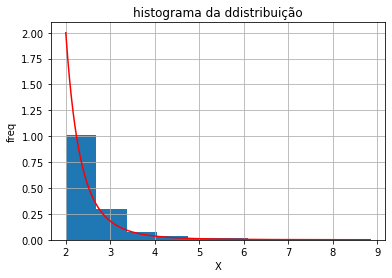

In [132]:
plot_hist(sample_q22,distribution_q22,ran2)

## Questão 3

Sendo I uma V.A indicadora que atribuí 1 caso se escolha um domínio existe do conjunto, D, de todos os possíveis domínios de tamanho k e 0 caso contrário. Sendo N o número de domínios existentes, podemos escrever que:

$$
\begin{equation}
I_i \sim Indicadora(p=\frac{1}{N}), i \in D
\end{equation}
$$

Definindo $X \sim Uniforme(1,|D|)$

$$
\begin{equation}
E[I(X)] = \frac{N}{|D|} \implies N = |D|E[I(X)]
\end{equation}
$$

Um método de Monte Carlo neste caso é aproximar a expectativa da equação acima pela média amostral. Infelizmene o uso da distribuição uniforme vai fazer o estimador bastante ineficiente já que o número de domínios existentes deve ser muito menor que o número de possíveis domínios.

In [10]:
def assert_url_exists(url):
    try:
        r = requests.get(url)
        return True
    except:
        return False

def assert_url_exists_parallel(urls):
    return np.array([ assert_url_exists(u) for u in urls])

In [15]:
def gen_k_size_string(shape):
    
    def to_string(v):
        to_char = [chr(i) for i in v]
        return ''.join(to_char)
    
    def shorten_string(s):
        l = len(s) + 1
        size = np.random.randint(1,l)
        return s[0:size]

    rands = np.random.randint(97,122, shape)
    rands_shorten = [shorten_string(s) for s in rands]
    rands_char = [to_string(s) for s in rands_shorten]
    
    return rands_char, rands_shorten

In [16]:
def sample_urls(sample_sz, k):
    shape = (sample_sz, k)
    rands, x = gen_k_size_string(shape)
    return ["http://www." + d + ".ufrj.br" for d in rands], x

def sample_url_exists(sample_sz):
    url_sampĺe, _ = sample_urls(sample_sz,4)
    return assert_url_exists_parallel(url_sampĺe), url_sampĺe

In [17]:
cardD = 26**4 + 26**3 + 26**2 + 26

def N_estimator(sample):
    global cardD
    return cardD*sanple_mean_estimator(sample)

In [18]:
def run_url_experiments(min_sample_sz, max_sample_sz):
    global sample_url_exists, run_mc_estimator, mae, N_estimator
    
    range_len = max_sample_sz - min_sample_sz + 1
    estimates = np.zeros([5, range_len])
    
    for i,sample_sz in enumerate(tqdm(range(min_sample_sz, max_sample_sz + 1))):
        url_sampĺe, _ = run_mc_estimator(sample_url_exists, sample_sz, mae, N_estimator, None, num_folds=5)
        estimates_for_n = assert_url_exists(url_sampĺe)
        estimates[:,i] = estimates_for_n
    
    return estimates

In [22]:
%%time
max_sample_sz = int(1e2)
estimates = run_url_experiments(5,max_sample_sz)

100%|██████████| 96/96 [21:33<00:00, 19.88s/it]

CPU times: user 19.6 s, sys: 605 ms, total: 20.2 s
Wall time: 21min 33s


In [25]:
def plot_experiment2(estimates):
    
    fig = plt.figure(figsize=(10, 8))
    plt.title('estimativa usando MC')
    plt.plot(estimates.T, 'x', color='blue');
    plt.grid(True)
    plt.xlabel('tamanho da amostra')
    plt.ylabel('estimativa')
    
    plt.show()

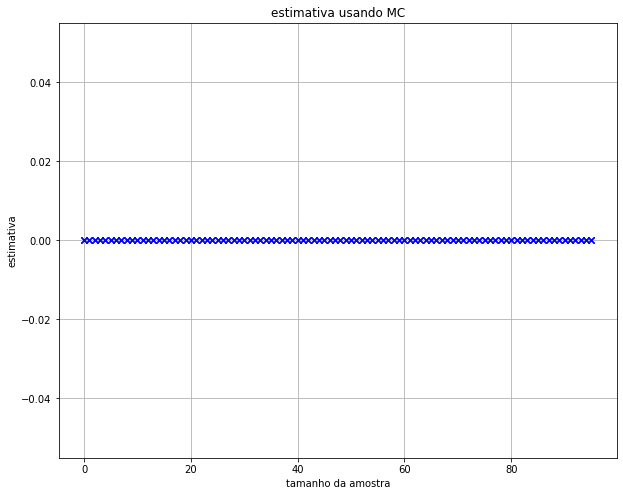

In [24]:
plot_experiment2(estimates)

## Questão 5
<!-- 
Sabemos que, se utilizarmos a distribuição h(i) para amostrar a função $g(i)/h(i)$ temos que:

$$
\begin{equation}
\sigma_{estimador} = \sum_{i=1}^N\frac{g(i)^2}{h(i)}
\end{equation}
$$

O melhor estimador é aquele de variância mínima, logo:

$$
\begin{equation}
\frac{d\sigma_{estimador}}{di} = \sum_{i=1}^N\left(\frac{2g(i)g(i)'}{h(i)} - \frac{g(i)^2}{h(i)^2}h(i)'\right)
\end{equation}
$$

onde $h(i)' = \frac{dh(i)}{di}$ e $g(i)' = \frac{dg(i)}{di}$. O estimador de variância mínima terá:

$$
\begin{equation}
0 = \frac{d\sigma_{\text{melhor estimador}}}{di} \implies \sum_{i=1}^N\left(\frac{2g(i)g(i)'}{h(i)} - \frac{g(i)^2}{h(i)^2}h(i)'\right) = 0
\end{equation}
$$

Para o caso particular $g(i) = i log(i)$ e $g(i)' = 1 + log(i)$ 

$$
\begin{equation}
0 = \sum_{i=1}^N\left(\frac{2i\log(i)(1+ log(i))}{h(i)} - \frac{(i\log(i))^2}{h(i)^2}h(i)'\right)
\end{equation}
$$

Em particular, $h(i) = k i\log i$, é solução para a equação acima. Onde podemos escolher o valor da constante k, tal que a a função h(i) seja uma função de densidade válida

$$
\begin{equation}
1 = \sum_{i=1}^N k i\log i = k\sum_{i=1}^N i\log i \implies k = \frac{1}{\sum_{i=1}^N i\log i}
\end{equation}
$$

Para essa escolha de h(i):

$$
\begin{equation}
\sigma_{estimador} = \sum_{i=1}^N\frac{i\log i}{k}
\end{equation}
$$

Para essa distribuição gerar amostrar usando o método da função inver

$$
\begin{equation}
F_{h(i)} = 
\end{equation}
$$ -->

In [45]:
def fun_h (x):
    return x*math.log(x)

In [49]:
def plot_fun_g_q5():
    interval1N = np.linspace(0.1,5,100)
    fun_h_sample = [fun_h(i) for i in interval1N]
    plt.plot(interval1N,fun_h_sample)
    plt.grid(True)
    plt.show()

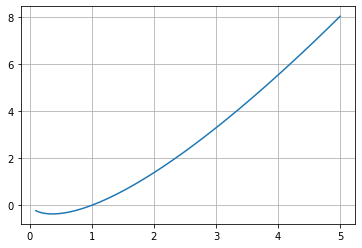

In [50]:
plot_fun_g_q5()

o gráfico lembra uma parábola de zeros em 0 e 1. Isso motiva minha escolha de h(i):

$$
\begin{equation}
h(i) = k(x^2 - x)
\end{equation}
$$

para o cálculo de k, utilizaremos a restrição que h(i) seja uma densidade de probabilidade no intervalo [0,1]

$$
\begin{equation}
1 = \sum_{i=1}^N(x^2 - x)k \implies k = \frac{1}{\sum_{i=1}^N(x^2 - x)}
\end{equation}
$$

Usando as somas das séries de potência:

$$
\begin{equation}
    S_1(n) = \sum_{i=1}^{n}i = \frac{n(n+1)}{2}
\end{equation}
$$
$$
\begin{equation}
    S_2(n) = \sum_{i=1}^{n}i^2 = \frac{n(n+1)(2n+1)}{6}
\end{equation}
$$

$$
\begin{equation}
k = \frac{1}{\frac{N(N+1)(2N+1)}{6} - \frac{N(N+1)}{2}} = \frac{6}{N(N+1)(2N+1) - 3N(N+1)} = \frac{3}{N(N^2-1)}
\end{equation}
$$

### Questão 5.1

Para essa escolha de h(i), e excluindo o valor em i=1, que gera uma singularidade:

$$
\begin{equation}
\sigma_{estimador}^2 = E\left[\frac{g(i)^2}{h(i)}\right[ = E\left[\frac{(i\log i)^2}{k(i^2 - i)}\right]
\end{equation}
$$

Para $N = 10^6 \implies k = 2.999999999997\times 10^{-18}$


In [12]:
N = int(1e6)
k = 2.999999999997e-18

In [13]:
def g2_por_h(x):
    return x*math.log(x)/(2.999999999997e-18*(x**2 - x))

def fun_h_q5(x):
    return (x**2 - x)*2.999999999997e-18

var_estimador = np.sum([g2_por_h(x)*fun_h_q5(x) for x in range(2,N+1)])

In [14]:
print(f"O valor da variância do estimador para a escolha de h(i) é de {'%.2E' % Decimal(var_estimador)}")

O valor da variância do estimador para a escolha de h(i) é de 6.66E+12


In [15]:
var_estimador_uniforme = np.mean([g2_por_h(x) for x in range(2,N+1)])

In [16]:
print(f"A variância do estimador uniforme é {'%.2E' % Decimal(var_estimador_uniforme)}")

A variância do estimador uniforme é 3.22E+13


### Questão 5.2

infelizmente a função h(i) é complicada de ser amostrada, embora a cumulativa seja uma cúbica e por existir uma fórmiula fechada para as raízes eu acredito que seja possível usar isso para criar amostras pelo método da inversa. Como alternativa vou utilizar o método de rejection sampling a partir da univorme, o que não é computacionalmente eficiente

In [17]:
def rejection_sampling(sample_sz, target_fun, envelop_fun, envelop_fun_sample_gen, max_loop_size=int(1e8)):
    accepted = []
    x_generator = []
    for i in range(0,max_loop_size):
        if (len(accepted) >= sample_sz):
            break
        x = envelop_fun_sample_gen()
        q_i = target_fun(x)
        u = np.random.uniform(0, envelop_fun(x))
        if u < q_i:
            x_generator.append(u)
            accepted.append(x)
    return np.array(accepted), x_generator

In [18]:
c = N*k*(N**2-N)

In [19]:
def uniform_envelop_fun(x):
    return c/N

def envelop_fun_sample_gen():
    return np.random.randint(1,N)

In [20]:
def importance_sampling_estimator(h_sample):
    return np.mean([g2_por_h(x) for x in h_sample])

In [21]:
def h_sample_gen(sample_sz):
    global  fun_h_q5, uniform_envelop_fun, envelop_fun_sample_gen
    return rejection_sampling(sample_sz, fun_h_q5, uniform_envelop_fun, envelop_fun_sample_gen)

In [22]:
q5_true_val = np.sum([x*math.log(x) for x in range(1, N+1)])

In [23]:
def run_experiments_q5(min_sample_sz, max_sample_sz):
    global h_sample_gen, importance_sampling_estimator, mae, q5_true_val
    
    true_val = q5_true_val
    range_len = max_sample_sz - min_sample_sz + 1
    estimates = np.zeros([5, range_len])
    errors = np.zeros([5, range_len])
    for i,sample_sz in enumerate(tqdm(range(min_sample_sz, max_sample_sz + 1))):
        estimates_for_n, error_samples_for_n = run_mc_estimator(h_sample_gen, sample_sz, mae, importance_sampling_estimator, true_val)
        estimates[:,i] = estimates_for_n
        errors[:,i] = error_samples_for_n
    return estimates, errors

In [24]:
estimates_q5, error_q5 = run_experiments_q5(5,int(1e4))

100%|██████████| 9996/9996 [33:39<00:00,  2.43it/s]


Os gráficos abaixo demonstram a convergência do estimador criado a partir da distribuiçao h(i) quadrática amostrada pelo método de rejection sampling.

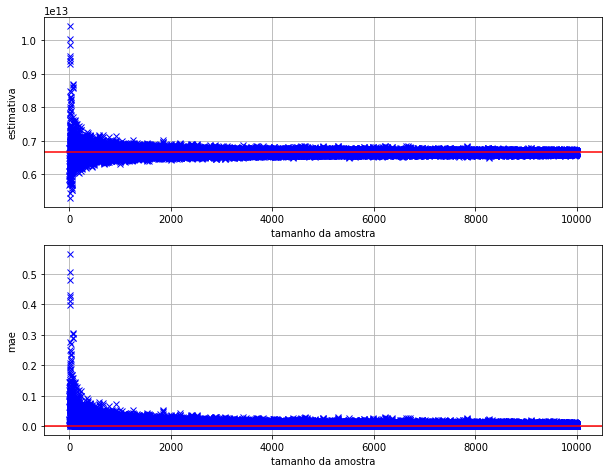

In [27]:
plot_experiment1(estimates_q5, error_q5, q5_true_val)